### Figure S: Day 3 of fixX experiment 

Here we create supplementary Figure S... .

In [1]:
import os
print(os.getcwd())
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
ball_blue=(0.13, 0.67, 0.8)

C:\Users\mathuser\Google Drive\Python\Jupyter Notebook\PNAS figures


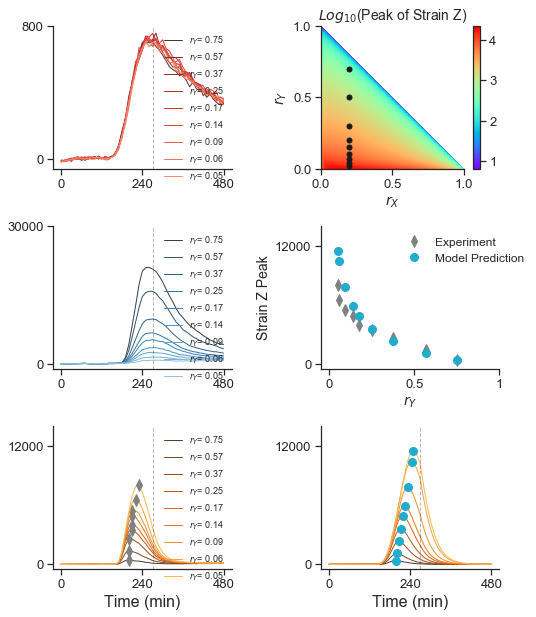

In [3]:
# Load the data from matlab .mat file
fixXData = sio.loadmat('fixX.mat')
numDataPoints=len(fixXData['all_flu'][:,0,0,0,0])
time_vec=np.array(range(0,numDataPoints*10,10))
ts=270 #start of the saturation pahse of the cell growth 


 
sns.set()
sns.set(font_scale=1.2)
sns.set_style('ticks')
red_colors = sns.color_palette("Reds_d",9)
blue_colors = sns.color_palette("Blues_d",9)
orange_colors = sns.color_palette("YlOrBr_d",9)
Fig3 = plt.figure(figsize=(8,10))


#Store the data for all 9 conditions of day 3 of fixX (mean of 6 replicates)
day=2 #day 3 of the fixX experiment
X_9cond=np.zeros([numDataPoints, 9])
Y_9cond=np.zeros([numDataPoints, 9])
Z_9cond=np.zeros([numDataPoints, 9])
for c in range(9):
    X_reps=np.zeros([numDataPoints, 6])
    Y_reps=np.zeros([numDataPoints, 6])
    Z_reps=np.zeros([numDataPoints, 6])
    for repl in range(6):
        X=fixXData['all_flu'][:,repl,c,0,day]
        Y=fixXData['all_flu'][:,repl,c,1,day]
        Z=fixXData['all_flu'][:,repl,c,2,day]
        X=X-np.mean(X[0:11])
        Y=Y-np.mean(Y[0:11])
        Z=Z-np.mean(Z[0:11])
        X_reps[:, repl]=X
        Y_reps[:, repl]=Y
        Z_reps[:, repl]=Z
    X_9cond[:,c] = np.mean(X_reps, axis=1)
    Y_9cond[:,c] = np.mean(Y_reps, axis=1)
    Z_9cond[:,c] = np.mean(Z_reps, axis=1)


measured_fracs = sio.loadmat('measured_fracs_time0.mat')
exper = 1 #fixX
day=2 #day 3 of the fixX experiment
rX = measured_fracs['measured_fracs_time0'][0,:,day, exper]   #strain X
rY = measured_fracs['measured_fracs_time0'][1,:,day, exper]   #strain Y

#Plot 9 conditions of fixX experiment for strain X 
plt.subplot(3,2,1)
for c in range(9):
    plt.plot(time_vec,X_9cond[:,c], color=red_colors[c], lw=1, label='$r_Y$= {0:1.2f}'.format(rY[c]))   
plt.axvline(ts, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.xticks((0,240,480),(0,240,480))
plt.yticks((0,800),(0,800))
sns.despine()

#Plot 9 conditions of fixX experiment for strain Y 
plt.subplot(3,2,3)
for c in range(9):
    plt.plot(time_vec,Y_9cond[:,c], color=blue_colors[c], lw=1, label='$r_Y$= {0:1.2f}'.format(rY[c]))    
plt.axvline(ts, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.xticks((0,240,480),(0,240,480))
plt.yticks((0,30000),(0,30000))
sns.despine()

#Plot 9 conditions of fixX experiment for strain Z 
plt.subplot(3,2,5)
for c in range(9):
    plt.plot(time_vec,Z_9cond[:,c], color=orange_colors[c], lw=1, label='$r_Y$= {0:1.2f}'.format(rY[c]))  
    ind = np.argmax(Z_9cond[:,c])
    plt.plot(ind*10, Z_9cond[ind,c], linestyle='none', marker='d', markersize=8, color='gray')
plt.axvline(ts, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=9, frameon=False)
plt.xticks((0,240,480),(0,240,480))
plt.ylim([-500, 14000])
plt.yticks((0,12000),(0,12000))
plt.xlabel('Time (min)', fontsize=16)
sns.despine()




#Create the simplex and the heatmap
plt.subplot(3,2,2)
simplex_peaks = sio.loadmat('simplexData.mat')
p = simplex_peaks['fluo_peak']
ell = len(p)
peaks = np.zeros([ell, ell])
for i in range(ell):
    for j in range(ell):
        peaks[ell-j-1, i] = p[i, j]
peaks[peaks<1e-6] = 1e-1
logPeaks = np.log10(peaks)
logPeaks[logPeaks<0] = float('nan')
plt.imshow(logPeaks, cmap='rainbow', extent=[0,1,0,1])
plt.colorbar()
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
#show the experimental ratio points
set_fracs = sio.loadmat('target_fracs.mat')
Rs=set_fracs['ideal_fracs'][:,:,1]
plt.plot(Rs[0,], Rs[1,], marker='o', color='k', markersize=5, linestyle='none')
plt.xlabel('$r_X$', fontsize=14)
plt.ylabel('$r_Y$', fontsize=14)
plt.title('$Log_{10}$(Peak of Strain Z)', fontsize=14)
sns.despine()



#Plot the model prediction for the peaks of fix X experiment
plt.subplot(3,2,4)  
p = fixXData['fixX_peaks'][:,2] #gets the experimental peaks of day 3

#Now find the model peak values
#Define the model here
def iffl(x, t, *pars):
    #parameters   
    r1, r2, ts, K_t, n, t_induc, lam, C_t, alpha_t1, alpha_t2, alpha_t3, D_t1, D_t2, D_t3, alpha_s1_tt, alpha_s2_tt = pars
    
    r3=1-r1-r2
    
    dx = np.zeros(6)
    # total cell population
    dx[0]    = lam*x[0]*(1-x[0]/C_t) 
    # protein concentrations
    Hill_XtoY = x[4]**n/(1+x[4]**n)
    Hill_XtoZ = Hill_XtoY
    Hill_YtoZ= 1/(1+x[5]**n)
    I = t>t_induc and t<ts
    dx[1]    = alpha_t1*r1*x[0]*I - D_t1*r1*x[0]*x[1]/(K_t*r1*x[0]+x[1])
    dx[2]    = alpha_t2*r2*x[0]*Hill_XtoY*I - D_t2*r2*x[0]*x[2]/(K_t*r2*x[0]+x[2])
    dx[3]    = alpha_t3*r3*x[0]*Hill_XtoZ*Hill_YtoZ*I - D_t3*r3*x[0]*x[3]/(K_t*r3*x[0]+x[3])
    # signal concentrations
    dx[4]    = 10**(-alpha_s1_tt)*x[1]
    dx[5]    = 10**(-alpha_s2_tt)*x[2]
    return dx

def findPeak(r1, r2, *pars):
    ts, K_t, n, t_induc, lam, C_t, alpha_t1, alpha_t2, alpha_t3, D_t1, D_t2, D_t3, alpha_s1_tt, alpha_s2_tt, N0 = pars
    #### Integrate the ODE of the model
    p_vec1 = (r1, r2, *pars) 
    p_vec = p_vec1[0:-1]
    y_init = np.append(N0,np.zeros(5)) 
    time_vec = np.linspace(0, ts, 541)
    sol = odeint(iffl, y_init, time_vec, args=p_vec)
    p = max(sol[:,3])
    return p

#set parameters of the model
ts = 270.0
K_t = 3.6e4 
n = 2
t_induc = 120.0
#from fitting 10 pars
MAP_pars=(0.0205148731, 0.73775627, 185.218336, 1327.094864, 1404.72118, \
                         152.326606, 326.004401, 1393.860552, 3.5934674, 4.64180206)
#lam, C_t, alpha_t1, alpha_t2, alpha_t3, D_t1, D_t2, D_t3, alpha_s1_tt, alpha_s2_tt = MAP_pars
N0 = 0.008577
params = (ts, K_t, n, t_induc, *MAP_pars, N0)
model_p = np.zeros(9)
for i in range(9):
    model_p[i] = findPeak(rX[i], rY[i], *params)    
plt.plot(rY, p, marker = 'd', markersize=8, linestyle='none', color='gray', label='Experiment')
plt.xlim([-.05, 1])
plt.xticks((0,0.5,1),(0,0.5,1))
plt.xlabel('$r_Y$', fontsize=14)
plt.ylim([-500, 14000])
plt.ylabel('Strain Z Peak', fontsize=14)
plt.yticks([0, 12000])
plt.plot(rY, model_p, marker = 'o', markersize=8, linestyle='none', color=ball_blue, label='Model Prediction')
plt.legend(fontsize=12, frameon=False, bbox_to_anchor=(1.2, 1))
sns.despine()



#Create the subplot for the strain Z dynamics predicted by the model
plt.subplot(3,2,6)  

def solveiffl(r1, r2, time_vec, *pars):
    ts, K_t, n, t_induc, lam, C_t, alpha_t1, alpha_t2, alpha_t3, D_t1, D_t2, D_t3, alpha_s1_tt, alpha_s2_tt, N0 = pars
    #### Integrate the ODE of the model
    p_vec1 = (r1, r2, *pars) 
    p_vec = p_vec1[0:-1]
    y_init = np.append(N0,np.zeros(5)) 
    sol = odeint(iffl, y_init, time_vec, args=p_vec)
    return sol

tf = 480
time_vec = np.linspace(0, tf, 250)
for i in range(9):
    sol = solveiffl(rX[i], rY[i], time_vec, *params)
    plt.plot(time_vec, sol[:,3], color=orange_colors[i], lw=1)
    ind = np.argmax(sol[:,3])
    plt.plot(time_vec[ind], sol[ind,3], linestyle='none', marker='o', markersize=8, color=ball_blue)
plt.axvline(ts, linestyle='--', color='k', lw=1, alpha=0.3)
plt.xticks((0,240,480),(0,240,480))
plt.ylim([-500, 14000])
plt.yticks((0,12000),(0,12000))
plt.xlabel('Time (min)', fontsize=16)
sns.despine()

#export figure
Fig3.subplots_adjust(wspace=0.5, hspace=0.4)
Fig3.savefig("FigS_fixX_d3.pdf", bbox_inches='tight', transparent=True)